In [1]:
import py7zr
import os

# Get all 7z files in current directory
zip_files = [f for f in os.listdir() if f.endswith('.7z')]

# Extract each 7z file
for zip_file in zip_files:
    with py7zr.SevenZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
        print(f"Extracted {zip_file}")


Extracted sample_submission.csv.7z
Extracted test.csv.7z
Extracted oil.csv.7z
Extracted train_.csv.7z
Extracted items.csv.7z
Extracted transactions.csv.7z
Extracted holidays_events.csv.7z
Extracted stores.csv.7z


In [13]:
import pandas as pd

# Load the training data
train_df = pd.read_csv('train.csv')
print("Train data shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())

/tmp/ipykernel_8669/3072673543.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train.csv')


Train data shape: (125497040, 6)

First few rows:
   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN


In [140]:
import datetime
items_df = pd.read_csv('items.csv')
non_perishable_items = items_df[items_df['perishable'] == 0]['item_nbr'].tolist()
train_df_filtered = train_df[train_df['item_nbr'].isin(non_perishable_items)]

# time cutoff
date_cutoff = datetime.datetime(2016, 4, 16)
# Get the weekday of 2013/1/1 as the start weekday
start_weekday = pd.Timestamp('2013-01-01').weekday()

date_cutoff = date_cutoff - pd.to_timedelta((date_cutoff.weekday() - start_weekday) % 7, unit='D')
train_df_filtered['date'] = pd.to_datetime(train_df_filtered['date'])
train_df_filtered = train_df_filtered[train_df_filtered['date'] < date_cutoff]

print(f"Original training data shape: {train_df.shape}")
print(f"Filtered training data shape: {train_df_filtered.shape}")

weekday_diff = ((train_df_filtered['date'].dt.weekday - start_weekday) % 7).astype(int)
train_df_filtered['WeekStart'] = pd.to_datetime(train_df_filtered['date'].dt.date) - pd.to_timedelta(weekday_diff, unit='D')

df_ts = train_df_filtered.groupby(['item_nbr', 'store_nbr', 'WeekStart'])['unit_sales'].sum().reset_index()
df_ts = df_ts.pivot(index=['item_nbr', 'store_nbr'], 
                    columns='WeekStart', 
                    values='unit_sales').reset_index()
df_ts = df_ts.fillna(0)
df_ts = df_ts.sort_values(['item_nbr', 'store_nbr'])

num_weeks = len(df_ts.columns) - 2  # Subtract 2 for 'Item Number' and 'Store Number' columns
zero_sales_count = (df_ts.iloc[:, 2:] == 0).sum(axis=1)  # Count zeros starting from 3rd column
zero_sales_pct = zero_sales_count / num_weeks

df_ts_filtered = df_ts[zero_sales_pct <= 0.1]
df_ts_filtered.columns.name = None
print(f"Filtered time series data shape: {df_ts_filtered.shape}")

# Filter for items with at least one sale in first 16 periods
first_16_periods = df_ts_filtered.columns[2:18]  # Skip item_nbr and store_nbr columns
has_early_sales = (df_ts_filtered[first_16_periods] > 0).any(axis=1)
df_ts_filtered = df_ts_filtered[has_early_sales]
print(f"Data shape after filtering for early sales: {df_ts_filtered.shape}")

/tmp/ipykernel_8669/3436127639.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered['date'] = pd.to_datetime(train_df_filtered['date'])


Original training data shape: (125497040, 6)
Filtered training data shape: (57061239, 6)


In [145]:
df_ts_filtered

,item_nbr,store_nbr,2013-01-01 00:00:00,2013-01-08 00:00:00,2013-01-15 00:00:00,2013-01-22 00:00:00,2013-01-29 00:00:00,2013-02-05 00:00:00,2013-02-12 00:00:00,2013-02-19 00:00:00,...,2016-02-02 00:00:00,2016-02-09 00:00:00,2016-02-16 00:00:00,2016-02-23 00:00:00,2016-03-01 00:00:00,2016-03-08 00:00:00,2016-03-15 00:00:00,2016-03-22 00:00:00,2016-03-29 00:00:00,2016-04-05 00:00:00
56,103501,9,63.0,27.0,51.0,44.0,54.0,50.0,31.0,41.0,...,19.0,31.0,46.0,44.0,59.0,27.0,34.0,33.0,71.0,15.0
57,103501,10,41.0,38.0,35.0,33.0,45.0,37.0,31.0,36.0,...,8.0,8.0,6.0,3.0,20.0,23.0,20.0,11.0,21.0,18.0
58,103501,11,58.0,44.0,32.0,26.0,51.0,45.0,27.0,16.0,...,32.0,23.0,26.0,19.0,48.0,32.0,19.0,30.0,30.0,36.0
60,103501,13,36.0,26.0,26.0,29.0,38.0,18.0,25.0,23.0,...,13.0,9.0,5.0,5.0,10.0,81.0,8.0,7.0,14.0,11.0
62,103501,15,51.0,50.0,43.0,34.0,42.0,37.0,44.0,35.0,...,21.0,22.0,27.0,18.0,30.0,25.0,18.0,15.0,30.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57605,1147731,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,3.0,4.0,4.0,4.0,9.0,3.0,8.0,7.0,6.0
57606,1147731,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,10.0,6.0,12.0,5.0,7.0,9.0,11.0,9.0,8.0
57607,1147731,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,6.0,5.0,6.0,6.0,6.0,3.0,8.0,16.0,4.0
57609,1147731,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,10.0,10.0,20.0,11.0,6.0,10.0,14.0,11.0


In [146]:
import torch

item_store_pairs = df_ts_filtered[['item_nbr', 'store_nbr']].drop_duplicates()
store_counts = item_store_pairs.groupby('item_nbr')['store_nbr'].nunique()
items_46_stores = store_counts[store_counts == 46].index.tolist()

# Filter df_ts_filtered for these items
df_46 = df_ts_filtered[df_ts_filtered['item_nbr'].isin(items_46_stores)]

# Get dimensions
num_items = len(items_46_stores)
num_stores = 46
num_weeks = len(df_ts_filtered.columns) - 2  # Subtract item_nbr and store_nbr columns

# Create empty tensor
sales_tensor = torch.zeros((num_items, num_stores, num_weeks))

# Fill tensor with sales data
for i, item in enumerate(items_46_stores):
    item_data = df_46[df_46['item_nbr'] == item].sort_values('store_nbr')
    sales_tensor[i] = torch.tensor(item_data.iloc[:, 2:].values)

# Save tensor
torch.save(sales_tensor, 'weekly_sales.pt')

print(f"Created tensor with shape: {sales_tensor.shape}")
print(f"Number of items with sales in all 46 stores: {num_items}")


Created tensor with shape: torch.Size([109, 46, 171])
Number of items with sales in all 46 stores: 109


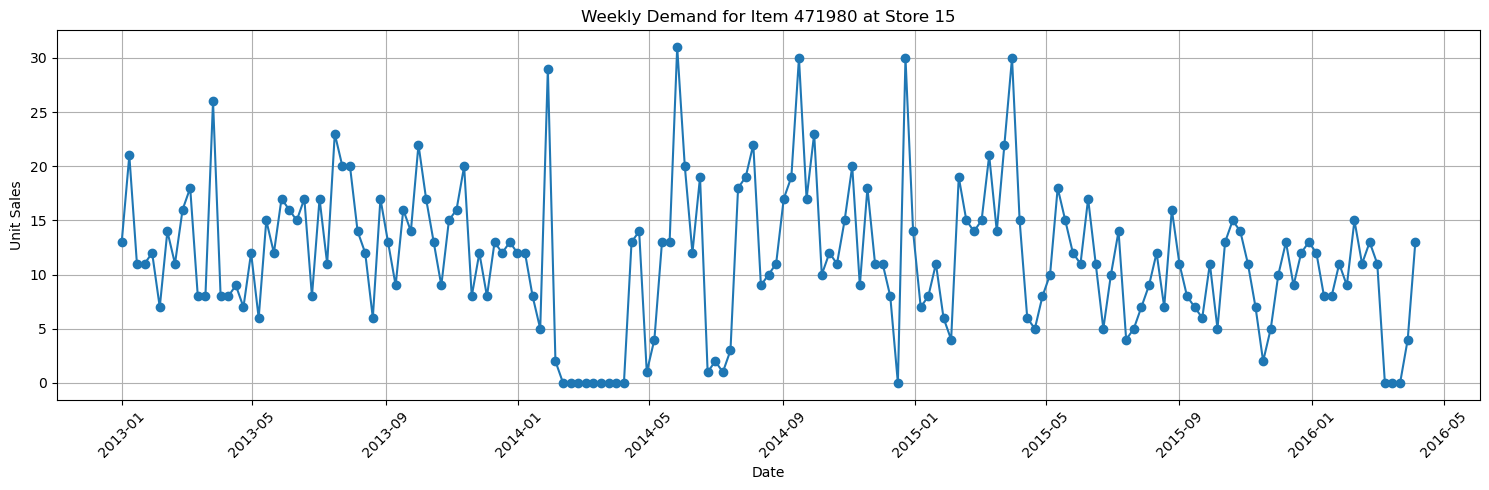

Selected Item Number: 471980
Selected Store Number: 15
Average weekly demand: 11.49
Maximum weekly demand: 31.00


In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly sample an item-store pair from the filtered dataset
random_pair = df_ts_filtered[['item_nbr', 'store_nbr']].sample(n=1).iloc[0]
item_nbr = random_pair['item_nbr']
store_nbr = random_pair['store_nbr']

# Get the row for specified item-store pair
selected_row = df_ts_filtered[(df_ts_filtered['item_nbr'] == item_nbr) & 
                            (df_ts_filtered['store_nbr'] == store_nbr)]

if len(selected_row) == 0:
    print(f"No data found for item {item_nbr} at store {store_nbr}")
else:
    # Get the demand sequence (all columns except item_nbr and store_nbr)
    demand_sequence = selected_row.iloc[0, 2:].values
    
    # Get dates from column names
    dates = pd.to_datetime(selected_row.columns[2:])

    # Create the plot
    plt.figure(figsize=(15, 5))
    plt.plot(dates, demand_sequence, '-o')
    plt.title(f'Weekly Demand for Item {item_nbr} at Store {store_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Selected Item Number: {item_nbr}")
    print(f"Selected Store Number: {store_nbr}")
    print(f"Average weekly demand: {demand_sequence.mean():.2f}")
    print(f"Maximum weekly demand: {demand_sequence.max():.2f}")


Number of items sold in exactly 1 store(s): 15
Number of items sold in exactly 2 store(s): 17
Number of items sold in exactly 3 store(s): 17
Number of items sold in exactly 4 store(s): 9
Number of items sold in exactly 5 store(s): 11
Number of items sold in exactly 6 store(s): 6
Number of items sold in exactly 7 store(s): 7
Number of items sold in exactly 8 store(s): 16
Number of items sold in exactly 9 store(s): 13
Number of items sold in exactly 10 store(s): 12
Number of items sold in exactly 11 store(s): 10
Number of items sold in exactly 12 store(s): 14
Number of items sold in exactly 13 store(s): 10
Number of items sold in exactly 14 store(s): 10
Number of items sold in exactly 15 store(s): 16
Number of items sold in exactly 16 store(s): 18
Number of items sold in exactly 17 store(s): 13
Number of items sold in exactly 18 store(s): 18
Number of items sold in exactly 19 store(s): 22
Number of items sold in exactly 20 store(s): 26
Number of items sold in exactly 21 store(s): 31
Numb

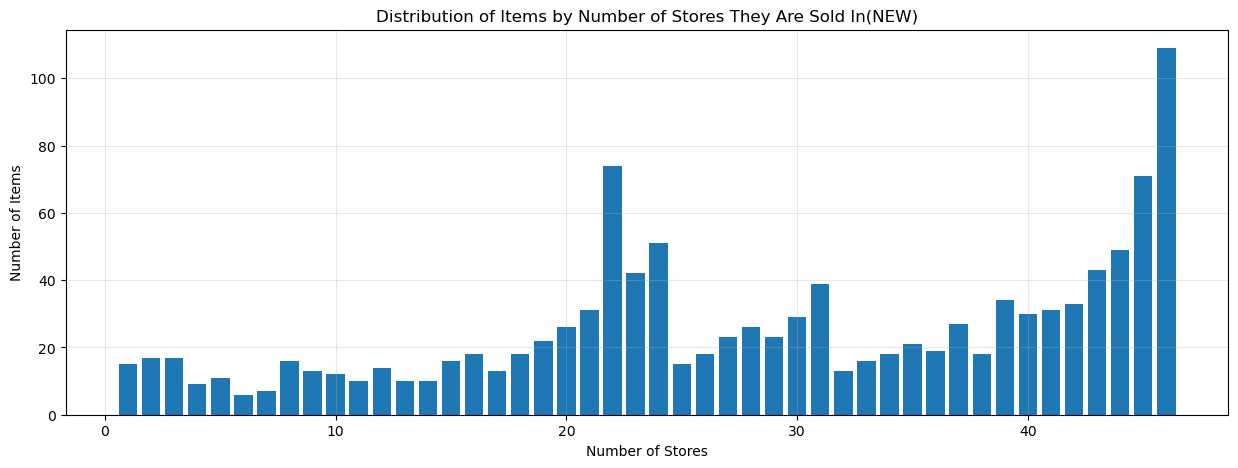

In [147]:
# Get the item-store combinations from our filtered dataset
item_store_pairs = df_ts_filtered[['item_nbr', 'store_nbr']].drop_duplicates()

# Group by item_nbr and count unique store_nbr for each item
store_counts = item_store_pairs.groupby('item_nbr')['store_nbr'].nunique()

# Determine the maximum number of stores any item is sold in
max_stores = store_counts.max()

# Initialize a dictionary to store the counts
store_distribution = {}

# Loop through each unique store count found and count how many items have that store count
for count in range(1, max_stores + 1):
    store_distribution[count] = (store_counts == count).sum()

ct = 0
# Printing the results
for stores, num_items in store_distribution.items():
    ct += stores * num_items
    print(f"Number of items sold in exactly {stores} store(s): {num_items}")

print(f"Total number of store-item pairs: {ct}")

# Create a bar plot of the store distribution
plt.figure(figsize=(15, 5))
plt.bar(store_distribution.keys(), store_distribution.values())
plt.title('Distribution of Items by Number of Stores They Are Sold In(NEW)')
plt.xlabel('Number of Stores')
plt.ylabel('Number of Items')
plt.grid(True, alpha=0.3)
plt.show()


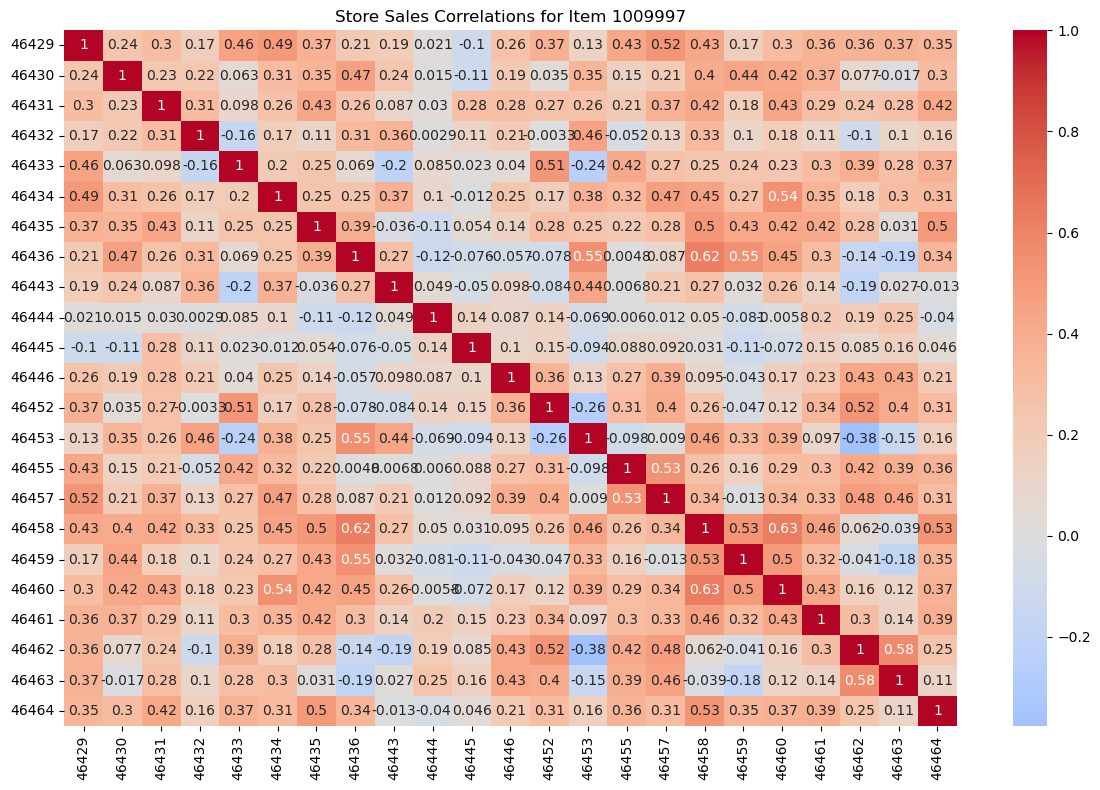


Analyzing Item Number: 1009997
Number of stores selling this item: 23

Correlation Summary:
Average correlation: 0.212
Maximum correlation: 0.626
Minimum correlation: -0.376


In [148]:
import seaborn as sns
# Randomly select an item number from unique item numbers
random_item = df_ts_filtered['item_nbr'].unique()
random_item = np.random.choice(random_item)

# Get data for this item across all stores
item_data = df_ts_filtered[df_ts_filtered['item_nbr'] == random_item]

# Get the weekly sales data for each store
store_sales = item_data.iloc[:, 2:] # Skip item_nbr and store_nbr columns
store_nbrs = item_data['store_nbr']
store_sales.columns = pd.to_datetime(store_sales.columns)
store_sales = store_sales.T # Transpose so stores are columns

# Calculate correlation matrix between stores
store_correlations = store_sales.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(store_correlations, annot=True, cmap='coolwarm', center=0)
plt.title(f'Store Sales Correlations for Item {random_item}')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nAnalyzing Item Number: {random_item}")
print(f"Number of stores selling this item: {len(store_sales.columns)}")
print("\nCorrelation Summary:")
print(f"Average correlation: {store_correlations.values[np.triu_indices_from(store_correlations, k=1)].mean():.3f}")
print(f"Maximum correlation: {store_correlations.values[np.triu_indices_from(store_correlations, k=1)].max():.3f}")
print(f"Minimum correlation: {store_correlations.values[np.triu_indices_from(store_correlations, k=1)].min():.3f}")

Overall Average Correlation Across All Items: 0.249


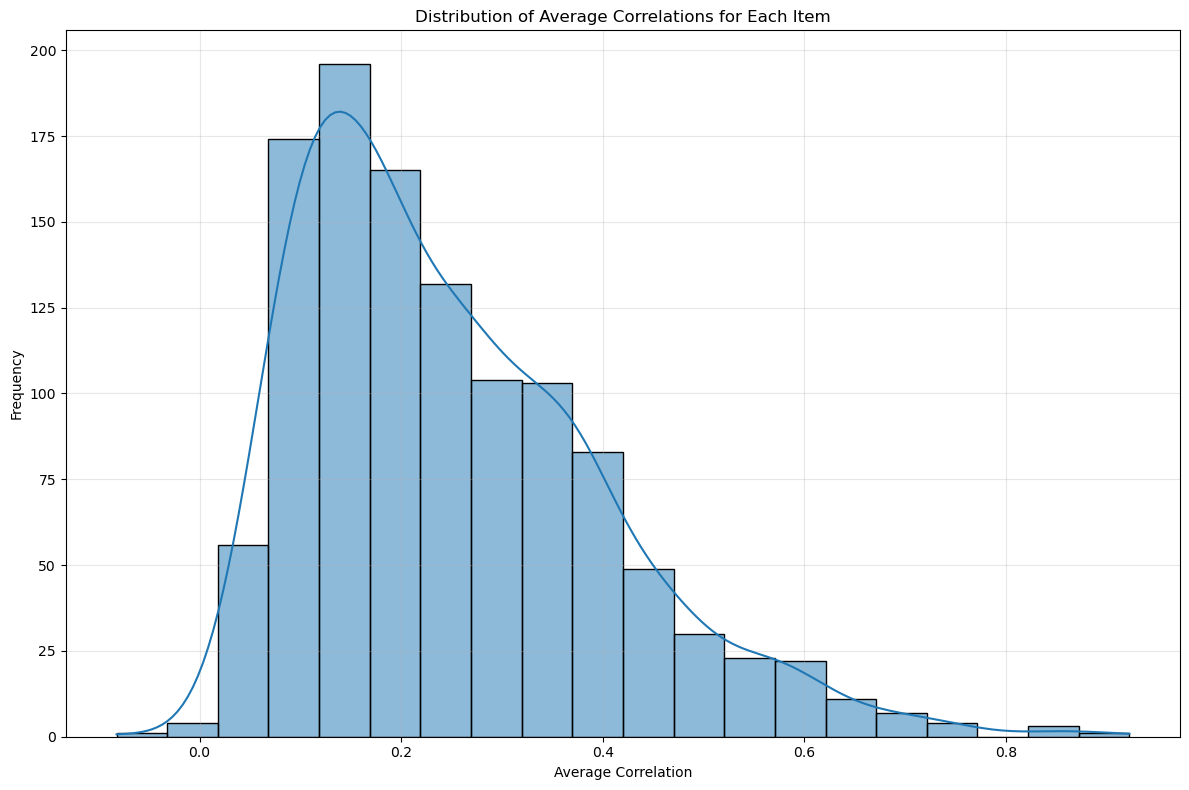

In [149]:
import seaborn as sns

# Get unique item numbers
unique_items = df_ts_filtered['item_nbr'].unique()
average_correlations = []
for item in unique_items:
    item_data = df_ts_filtered[df_ts_filtered['item_nbr'] == item]
    if len(item_data) <= 1:
        continue

    store_sales = item_data.iloc[:, 2:] # Skip item_nbr and store_nbr columns
    store_nbrs = item_data['store_nbr']
    store_sales.columns = pd.to_datetime(store_sales.columns)
    store_sales = store_sales.T # Transpose so stores are columns

    store_correlations = store_sales.corr()
    avg_corr = store_correlations.values[np.triu_indices_from(store_correlations, k=1)].mean()
    average_correlations.append(avg_corr)

overall_average_correlation = np.mean(average_correlations)
print(f"Overall Average Correlation Across All Items: {overall_average_correlation:.3f}")

plt.figure(figsize=(12, 8))
sns.histplot(average_correlations, bins=20, kde=True)
plt.title('Distribution of Average Correlations for Each Item')
plt.xlabel('Average Correlation')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
import torch

# Load the weekly sales tensor
weekly_sales = torch.load('/user/ml4723/Prj/NIC/data_files/favorita_one_warehouse_new/weekly_sales.pt')

# Print shape
print("Weekly sales tensor shape:", weekly_sales.shape)


Weekly sales tensor shape: torch.Size([109, 46, 171])
